In [1]:
# Python Language Version
from platform import python_version
print('Python Language Version Used in This Jupyter Notebook:', python_version())

Python Language Version Used in This Jupyter Notebook: 3.7.4


## Netflix's Movie Recommendation System

## Problem Definition

<p>
Netflix's goal is to connect people to the movies they love. To help customers find these movies, they have developed a world-class movie recommendation system: CinematchSM. We are going to to predict whether someone will like a movie based on how much they liked or disliked other movies. Netflix uses these predictions to make personal movie recommendations based on each customer's unique tastes. And although <b>Cinematch</b> is doing very well, it can always be improved.
</p>

Goals:

1. Predict the rating a user would give to a movie they haven't rated yet.
2. Minimize the difference between predicted and actual assessment (RMSE and MAPE).

## Data source

<p>
Netflix provided a lot of anonymized ranking data and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training dataset. Accuracy is a measure of how closely predicted movie ratings match subsequent actual ratings.
</p>

<ul>
<li> <a href="https://www.netflixprize.com/rules.html">Netflix Prize</a></li>
<li> <a href="https://www.kaggle.com/netflix-inc/netflix-prize-data">Dataset</a></li>

## Loading Packages

In [2]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

# Graphics formatting
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

## Loading the Data

To load the data we will perform the following operations:

- 1- Read the lines of all available files.
- 2- Combine all lines from all files into a single file.
- 3- Load the generated file into a pandas dataframe.

In [3]:
# Marks the beginning of the file reading execution.
start = datetime.now()

In [4]:
# We will create a final file called data.csv

# If the file does not exist, we create the file in write mode (w)
if not os.path.isfile('data/data.csv'):
    
    # Create and open the file for writing
    dataset = open('data/data.csv', mode = 'w')
    
    # List for lines of files
    linhas = list()
    
    # File names and paths
    files = ['data/combined_data_1.txt',
            'data/combined_data_2.txt', 
            'data/combined_data_3.txt', 
            'data/combined_data_4.txt']
    
    # Loop through each file in the file list
    for file in files:
        
        # Print
        print("Reading the file {}...".format(file))
        
        # With the file open, we extract the lines
        with open(file) as f:
            
            # Loop through each line of the file
            for row in f: 
                
                # Delete the contents of the list
                del rows[:] 
                
                # Split file lines by end-of-line character
                row = row.strip()
                
                # If we find a "colon" at the end of the line, we replace it by removing the character,
                # because we only want the id of the movie
                if row.endswith(':'):
                    movie_id = row.replace(':', '')
                    
                # If not, create a comprehension list to separate the columns by commas
                else:
                    
                    # Separate the columns
                    rows = [x for x in row.split(',')]
                    
                    # Use movie id at zero index position
                    rows.insert(0, movie_id)
                    
                    # Write the result to the new file
                    dataset.write(','.join(linhas))
                    dataset.write('\n')
                    
        print("Finished.\n")
        
    dataset.close()

In [5]:
# Print the total time
print('Total Time to Load Files:', datetime.now() - start)

Total Time to Load Files: 0:00:00.024933


In [6]:
print("Creating pandas dataframe from data file.csv...")
df_netflix = pd.read_csv('data/data.csv', sep = ',', names = ['movie', 'user', 'rating', 'date'])
df_netflix.date = pd.to_datetime(df_netflix.date)
print('Finished.')

Creating pandas dataframe from data file.csv...
Finished.


In [7]:
# Sorting the dataframe by date
print('Sorting dataframe by date..')
df_netflix.sort_values(by = 'date', inplace = True)
print('Finished.')

Sorting dataframe by date..
Finished.


In [8]:
# Shape
df_netflix.shape

(100480507, 4)

In [9]:
# Viewing the data
df_netflix.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


## Exploratory Data Analysis

In [10]:
# Data summary
print("Data summary")
print("-"*50)
print("Total Number of Films:", len(np.unique(df_netflix.movie)))
print("Total Number of Users:", len(np.unique(df_netflix.user)))
print("Total Number of Reviews:", df_netflix.shape[0])

Data summary
--------------------------------------------------
Total Number of Films: 17770
Total Number of Users: 480189
Total Number of Reviews: 100480507


In [11]:
# Let's save these two values to use later
total_users = len(np.unique(df_netflix.user))
total_movies = len(np.unique(df_netflix.movie))

In [12]:
# Checking the average of the ratings
df_netflix.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [13]:
# Checking for missing values
sum(df_netflix.isnull().any())

0

In [14]:
# Checking if we have duplicate values (in this case we don't consider the date)
sum(df_netflix.duplicated(['movie', 'user', 'rating']))

0

Let's split the data into training and testing before continuing with the exploratory analysis, as some analyzes only make sense for training data. We will use the 80/20 ratio for training/testing.

In [15]:
# We will create a dataset on disk with the training data
# That way we don't need to run the whole loading process again each time we run this notebook
if not os.path.isfile('data/training_data.csv'):
    df_netflix.iloc[:int(df_netflix.shape[0] * 0.80)].to_csv("data/training_data.csv", index = False)

In [16]:
# We will create a dataset on disk with the test data
# That way we don't need to run the whole loading process again each time we run this notebook
if not os.path.isfile('data/test_data.csv'):
    df_netflix.iloc[int(df_netflix.shape[0] * 0.80):].to_csv("data/test_data.csv", index = False)

In [17]:
# Delete the original dataframe to free memory
del df_netflix

In [18]:
# Now we load the files into pandas dataframes
df_netflix_train = pd.read_csv("data/training_data.csv", parse_dates = ['date'])
df_netflix_test = pd.read_csv("data/test_data.csv")

In [19]:
# Training data summary
print("Training data summary")
print("-"*50)
print("Total Number of Films:", len(np.unique(df_netflix_train.movie)))
print("Total Number of Users:", len(np.unique(df_netflix_train.user)))
print("Total Number of Reviews:", df_netflix_train.shape[0])

Training data summary
--------------------------------------------------
Total Number of Films: 17424
Total Number of Users: 405041
Total Number of Reviews: 80384405


In [20]:
# Test data summary
print("Test data summary")
print("-"*50)
print("Total Number of Films:", len(np.unique(df_netflix_test.movie)))
print("Total Number of Users:", len(np.unique(df_netflix_test.user)))
print("Total Number of Reviews:", df_netflix_test.shape[0])

Test data summary
--------------------------------------------------
Total Number of Films: 17757
Total Number of Users: 349312
Total Number of Reviews: 20096102


The function below will adjust the measurements in thousands, millions and billions to make the graphs easier to read.

In [21]:
# Function for setting the units of measure
def units_setting(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [22]:
# Supress warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

__Let's check the distribution of ratings.__

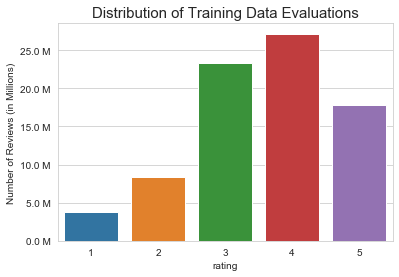

In [23]:
# Plot
fig, ax = plt.subplots()
plt.title('Distribution of Training Data Evaluations', fontsize = 15)
sns.countplot(df_netflix_train.rating)
ax.set_yticklabels([units_setting(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Number of Reviews (in Millions)')
plt.show()

__Does the day of the week influence the user's assessment? Let's add a column with the day of the week and find out.__

In [24]:
# Parameter to avoid warning due to high volume of data
pd.options.mode.chained_assignment = None  

In [25]:
# Extract the day of the week and write it to a new column
df_netflix_train['week_day'] = df_netflix_train['date'].dt.strftime("%A")
df_netflix_train.head()

,movie,user,rating,date,week_day
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


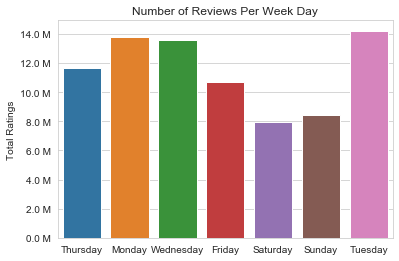

In [26]:
# Plot
fig, ax = plt.subplots()
sns.countplot(x = 'week_day', data = df_netflix_train, ax = ax)
plt.title('Number of Reviews Per Week Day')
plt.ylabel('Total Ratings')
plt.xlabel('')
ax.set_yticklabels([units_setting(item, 'M') for item in ax.get_yticks()])
plt.show()

__Let's calculate the average ratings per day of the week.__

In [27]:
# Average ratings per week day
average_week_day = df_netflix_train.groupby(by = ['week_day'])['rating'].mean()
print("Average Ratings")
print("-"*30)
print(average_week_day)
print("\n")

Average Ratings
------------------------------
week_day
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




The week days does not seem to have an influence on the user's evaluation.

__We will analyze user ratings over time.__

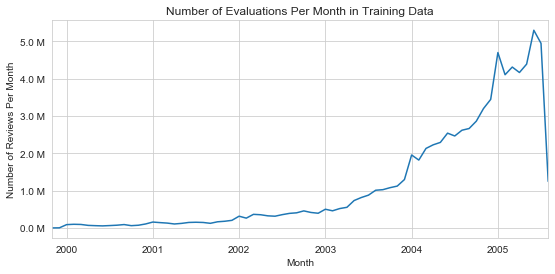

In [28]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax = df_netflix_train.resample('m', on = 'date')['rating'].count().plot()
ax.set_title('Number of Evaluations Per Month in Training Data')
plt.xlabel('Month')
plt.ylabel('Number of Reviews Per Month')
ax.set_yticklabels([units_setting(item, 'M') for item in ax.get_yticks()])
plt.show()

There is clearly an increase in user ratings over time, either due to more users or because users have learned to use the feature.

__Let's check the users who made the most movie ratings.__

In [29]:
# Ratings number per user
ratings_num_per_user = df_netflix_train.groupby(by = 'user')['rating'].count().sort_values(ascending = False)
ratings_num_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

In [30]:
# Statistical summary
ratings_num_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

__Let's create a plot of the probability density function function and the cumulative distribution function.__

The probability density function (pdf) and cumulative distribution function (cdf) are two of the most important statistical functions in reliability and are closely related. When these functions are known, almost any other reliability measure of interest can be derived or obtained.

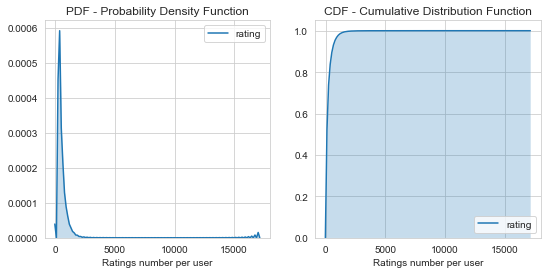

In [31]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax1 = plt.subplot(121)
sns.kdeplot(ratings_num_per_user, shade = True, ax = ax1)
plt.xlabel('Ratings number per user')
plt.title("PDF - Probability Density Function")
ax2 = plt.subplot(122)
sns.kdeplot(ratings_num_per_user, shade = True, cumulative = True, ax = ax2)
plt.xlabel('Ratings number per user')
plt.title('CDF - Cumulative Distribution Function')
plt.show()

Note that the vast majority of users have less than 1000 reviews.

__How many reviews are in the bottom 5% of all reviews?__

In [32]:
# Let's extract the percentiles
percentiles = ratings_num_per_user.quantile(np.arange(0,1.01,0.01), interpolation = 'higher')

In [33]:
# Viewing by 5
percentiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

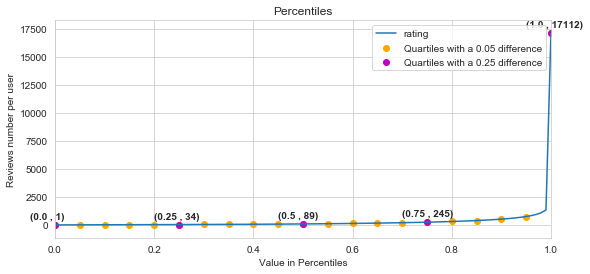

In [34]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.title("Percentiles")
percentiles.plot()

# Quartiles with a 0.05 difference
plt.scatter(x = percentiles.index[::5], 
            y = percentiles.values[::5], 
            c = 'orange', 
            label = "Quartiles with a 0.05 difference")

# Quartiles with a 0.25 difference
plt.scatter(x = percentiles.index[::25], 
            y = percentiles.values[::25], 
            c = 'm', 
            label = "Quartiles with a 0.25 difference")

# Labels and caption
plt.ylabel('Reviews number per user')
plt.xlabel('Value in Percentiles')
plt.legend(loc = 'best')

# Let's mark the 25th, 50th, 75th and 100th percentiles
for x,y in zip(percentiles.index[::25], percentiles[::25]):
    plt.annotate(s = "({} , {})".format(x,y), xy = (x,y), xytext = (x-0.05, y+500), fontweight = 'bold')

plt.show()

- There are some movies (which are very popular) that are rated by a large number of users.
    
- But most movies (like 90%) have a few hundred ratings.

## Sparse Matrix Creation

__Train Sparse Matrix Creation__

In [35]:
# We create the sparse matrix in Numpy format if it doesn't exist
# If it exists, just load it from disk
if os.path.isfile('data/train_sparse_matrix.npz'):
    train_sparse_matrix = sparse.load_npz('data/train_sparse_matrix.npz')
    print("Matrix loaded.")
else: 
    train_sparse_matrix = sparse.csr_matrix((df_netflix_train.rating.values, (df_netflix_train.user.values, 
                                                                                 df_netflix_train.movie.values)),)
    print('Matrix created. The shape is: (user, movie): ', train_sparse_matrix.shape)
    sparse.save_npz("data/train_sparse_matrix.npz", train_sparse_matrix)
    print('Matrix saved to disk.')

Matrix loaded.


In [36]:
# Calculate the matrix sparsity
rows, columns = train_sparse_matrix.shape
non_zero_elements = train_sparse_matrix.count_nonzero()
print("Training Matrix Sparsity : {} % ".format(  (1 - (non_zero_elements / (rows * columns))) * 100) )

Training Matrix Sparsity : 99.8292709259195 % 


__Test Sparse Matrix Creation__

In [37]:
# We create the sparse matrix in Numpy format if it doesn't exist
# If it exists, just load it from disk
if os.path.isfile('dados/test_sparse_matrix.npz'):
    test_sparse_matrix = sparse.load_npz('data/test_sparse_matrix.npz')
    print("Matrix loaded.")
else: 
    test_sparse_matrix = sparse.csr_matrix((df_netflix_test.rating.values, (df_netflix_test.user.values, 
                                                                               df_netflix_test.movie.values)))
    
    print('Matrix created. The shape is: (user, movie): ', test_sparse_matrix.shape)
    sparse.save_npz("data/test_sparse_matrix.npz", test_sparse_matrix)
    print('Matrix saved to disk.')

Matrix created. The shape is: (user, movie):  (2649430, 17771)
Matrix saved to disk.


In [38]:
# Calculate the matrix sparsity
rows, column = test_sparse_matrix.shape
non_zero_elements = test_sparse_matrix.count_nonzero()
print("Training Matrix Sparsity : {} % ".format(  (1 - (non_zero_elements / (rows * columns))) * 100) )

Training Matrix Sparsity : 99.95731772988694 % 


__Let's calculate the global average of all movie ratings, average rating per user and average rating per movie.__

In [39]:
# Global average of all user ratings.
train_avg = dict()
global_train_avg = train_sparse_matrix.sum() / train_sparse_matrix.count_nonzero()
train_avg['global'] = global_train_avg
train_avg

{'global': 3.582890686321557}

__Let's build a function to calculate the average rating.__

In [40]:
# Averaging function
def calculate_average_ratings(sparse_matrix, of_users):
    
    # Average user/axis ratings
     # 1 = user axis
     # 0 = film axis
    ax = 1 if of_users else 0

    # Sum
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    # Boolean array of ratings (whether a user rated a movie or not)
    is_rated = sparse_matrix!=0
    
    # Number of ratings for each user or movie
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # Maximum user and movie ids in sparse array
    u, m = sparse_matrix.shape
    
    # We created a dictionary of users and their average ratings.
    avg_ratings = {i:sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i]!=0}

    # Returns the rating average dictionary
    return avg_ratings

__Now we calculate the average of ratings per user.__

In [41]:
# Average User Ratings
train_avg['user'] = calculate_average_ratings(train_sparse_matrix, of_users = True)

In [42]:
# View the dictionary
train_avg

{'global': 3.582890686321557,
 'user': {6: 3.5160550458715596,
  7: 3.992957746478873,
  10: 3.3781094527363185,
  25: 3.5,
  33: 3.787878787878788,
  42: 3.9322033898305087,
  59: 3.698717948717949,
  79: 3.5559947299077734,
  83: 4.0,
  87: 3.544642857142857,
  94: 2.8125,
  97: 3.182377049180328,
  131: 4.0,
  134: 4.703081232492997,
  142: 3.45,
  149: 4.25,
  158: 3.625,
  168: 4.208333333333333,
  169: 3.738562091503268,
  178: 3.0,
  183: 3.7096774193548385,
  188: 3.4456066945606696,
  189: 3.0,
  192: 3.522222222222222,
  195: 3.689655172413793,
  199: 3.974747474747475,
  201: 3.605714285714286,
  242: 2.8392857142857144,
  247: 4.019230769230769,
  248: 3.6511627906976742,
  261: 2.769230769230769,
  265: 3.680297397769517,
  266: 4.102222222222222,
  267: 3.325,
  268: 4.008,
  283: 3.4794816414686824,
  291: 3.4745762711864407,
  296: 3.789473684210526,
  298: 3.8052805280528053,
  299: 3.5555555555555554,
  301: 4.05524861878453,
  302: 3.212,
  304: 3.8051948051948052,
 

In [43]:
# Print
print('Average User Rating 149 :', train_avg['user'][149])

Average User Rating 149 : 4.25


__Now we calculate the average of ratings per film.__

In [44]:
# Average Movie Ratings
train_avg['movie'] =  calculate_average_ratings(train_sparse_matrix, of_users = False)

In [45]:
# Print
print('Average Movie Rating 32 :', train_avg['movie'][32])

Average Movie Rating 32 : 3.9922680412371134


__Average PDFs and CDFs. User ratings and movies (training data).__

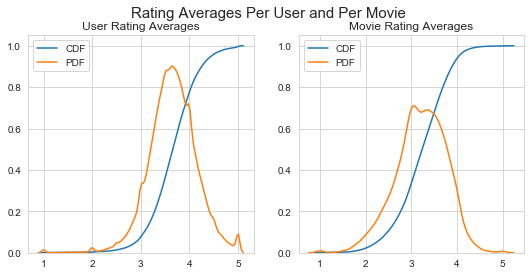

In [46]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = plt.figaspect(.45))
fig.suptitle('Rating Averages Per User and Per Movie', fontsize = 15)

ax1.set_title('User Rating Averages')

# We get the list of average user ratings from the average dictionary.
users_avg = [rat for rat in train_avg['user'].values()]
sns.distplot(users_avg, ax = ax1, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(users_avg, ax = ax1, hist = False, label = 'PDF')

ax2.set_title('Movie Rating Averages')

# We get the list of average movie ratings from the dictionary.
movies_avg = [rat for rat in train_avg['movie'].values()]
sns.distplot(movies_avg, ax = ax2, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(movies_avg, ax = ax2, hist = False, label = 'PDF')

plt.show()

## Cold Start Problem

In [47]:
# Users Cold start
train_users = len(train_avg['user'])
new_users = total_users - train_users

In [48]:
# Print
print('Grand Total of Users:', total_users)
print('Total Users in Training :', train_users)
print("Total Users Not in Training: {} ({}%)".format(new_users,
                                                                   np.round((new_users / total_users) * 100, 2)))

Grand Total of Users: 480189
Total Users in Training : 405041
Total Users Not in Training: 75148 (15.65%)


75148 users are not part of the training data, that is, we have no way of learning the evaluation pattern of these users! This is the cold start problem.

In [49]:
# Movies Cold start
train_movies = len(train_avg['movie'])
new_movies = total_movies - train_movies

In [50]:
# Print
print('Grand Total of Movies:', total_movies)
print('Total Films in Training:', train_movies)
print("Total Films Not in Training: {} ({}%)".format(new_movies,
                                                                 np.round((new_movies/total_movies)*100, 2)))

Grand Total of Movies: 17770
Total Films in Training: 17424
Total Films Not in Training: 346 (1.95%)


346 movies do not appear in the training data. We will have to deal with this when we work especially on the Machine Learning model.

## Calculating the User Similarity Matrix

In [51]:
# Similarity calculation function
def calculate_user_similarity(sparse_matrix, 
                                 compute_for_few = False, 
                                 top = 100, 
                                 verbose = False, 
                                 verb_for_n_rows = 20,
                                 draw_time_taken = True):
    
    # Control variables
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) 
    time_taken = list()
    rows, cols, data = list(), list(), list()
    if verbose: print("Calculating top", top, "similarities for each user...")
    start = datetime.now()
    temp = 0
    
    # Matrix Loop
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp + 1
        prev = datetime.now()
        
        # Calculating the cosine similarity
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("Completed calculation for {} users [  total time : {}  ]".format(temp, datetime.now()-start))
            
    if verbose: print('Creation of sparse matrix from computed similarities...')    
        
    if draw_time_taken:
        plt.plot(time_taken, label = 'Calculation time for each user')
        plt.plot(np.cumsum(time_taken), label = 'Total time')
        plt.legend(loc = 'best')
        plt.xlabel('Users')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape = (no_of_users, no_of_users)), time_taken      

Calculating top 100 similarities for each user...
Completed calculation for 20 users [  total time : 0:01:21.823198  ]
Completed calculation for 40 users [  total time : 0:02:42.962442  ]
Completed calculation for 60 users [  total time : 0:04:01.593251  ]
Completed calculation for 80 users [  total time : 0:05:20.324747  ]
Completed calculation for 100 users [  total time : 0:06:39.804223  ]
Creation of sparse matrix from computed similarities...


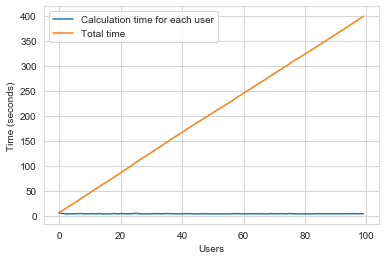

Total Processing Time: 0:06:51.595724


In [52]:
# Calculate the similarity

# Mark the start
start = datetime.now()

# Calculates the similarity
sparse_matrix_user, _ = calculate_user_similarity(train_sparse_matrix, 
                                                      compute_for_few = True, 
                                                      top = 100, 
                                                      verbose = True)

print("Total Processing Time:", datetime.now() - start)

We have **405,041 users** in our training set and computing similarities between them (**17K dimensional array**) is time consuming.


We will try to reduce the dimensions using SVD, in order to speed up the process.

## Dimensionality Reduction with TruncatedSVD

In [53]:
# Dimensionality reduction

# Mark the start
start = datetime.now()

# Creates TruncatedSVD object by reducing dimensionality to 80 dimensions
netflix_svd = TruncatedSVD(n_components = 80, algorithm = 'randomized', random_state = 15)

# Apply TruncatedSVD
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)

print("Total Processing Time:", datetime.now() - start)

Total Processing Time: 0:02:29.773465


__Let's calculate the variance explained by the components.__

In [54]:
# Calculates the explained variance
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

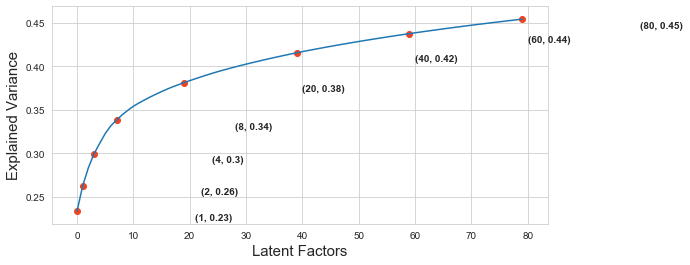

In [55]:
# Plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = plt.figaspect(.45))

ax1.set_ylabel("Explained Variance", fontsize = 15)
ax1.set_xlabel("Latent Factors", fontsize = 15)
ax1.plot(expl_var)

# Let's mark some combinations of (latent factors, explained variance) to make the graph clearer
ind = [1, 2, 4, 8, 20, 40, 60, 80]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c = '#ee4422')

for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy = (i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight = 'bold')

plt.show()

With 80 components we explain approximately 45% of the data variance. This is enough for our example.

In [56]:
# Let's project our array into 80-dimensional space
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print("Total Processing Time:", datetime.now() - start)

Total Processing Time: 0:00:05.359700


In [57]:
# Shape
trunc_matrix.shape

(2649430, 80)

In [58]:
# Type
type(trunc_matrix)

numpy.ndarray

In [59]:
# Let's create and save to disk the matrix with the dimensionality reduced to 80 dimensions
if not os.path.isfile('data/truncated_sparse_matrix_user.npz'):
    truncated_sparse_matrix_user = sparse.csr_matrix(trunc_matrix)
    sparse.save_npz('data/truncated_sparse_matrix_user', truncated_sparse_matrix_user)
else:
    truncated_sparse_matrix_user = sparse.load_npz('data/truncated_sparse_matrix_user.npz')

In [60]:
# Shape
truncated_sparse_matrix_user.shape

(2649430, 80)

__Now we recalculate the similarity of users using the truncated matrix.__

Calculating top 50 similarities for each user...
Completed calculation for 20 users [  total time : 0:00:19.442012  ]
Completed calculation for 40 users [  total time : 0:00:38.986719  ]
Creation of sparse matrix from computed similarities...


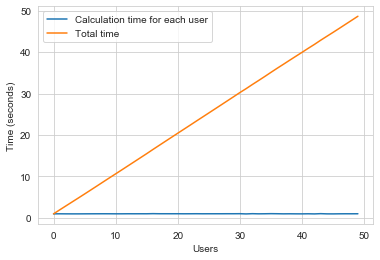

Total Processing Time: 0:00:52.963406


In [61]:
# Calculate similarity of users

# Mark the start
start = datetime.now()

# Calculates the similarity
trunc_sim_matrix, _ = calculate_user_similarity(truncated_sparse_matrix_user, 
                                                   compute_for_few = True, 
                                                   top = 50, 
                                                   verbose = True) 

print("Total Processing Time:", datetime.now() - start)

## Calculating Movie Similarity Matrix

In [62]:
# Calculation of movie similarity

# Mark the start
start = datetime.now()

# Create if it doesn't exist
if not os.path.isfile('data/sparse_matrix_movie.npz'):
    sparse_matrix_movie = cosine_similarity(X = train_sparse_matrix.T, dense_output = False)
    print("Matrix Created.")
    sparse.save_npz("data/sparse_matrix_movie.npz", sparse_matrix_movie)
    print("Matrix Saves in disk")
else:
    sparse_matrix_movie = sparse.load_npz("data/sparse_matrix_movie.npz")
    print("Matrix Loaded.")

print("Total Processing Time:", datetime.now() - start)

Matrix Created.
Matrix Saves in disk
Total Processing Time: 0:08:01.174500


In [63]:
# Shape
sparse_matrix_movie.shape

(17771, 17771)

In [64]:
# Extract movie ids
movie_ids = np.unique(sparse_matrix_movie.nonzero()[1])

In [65]:
# Calculate the similarity of movies according to the rating pattern of users

# Mark the start
start = datetime.now()

# Dictionary to store similarities
similar_movies = dict()

# Loop through movie ids
for movie in movie_ids:
    # Get the top similar movies and store them in the dictionary
    sim_movies = sparse_matrix_movie[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
    
print("Total Processing Time:", datetime.now() - start)

Total Processing Time: 0:00:29.393400


In [66]:
# Movies similar to id 43's movie
similar_movies[43]

array([ 6938,  3353, 15088, 14888,  7550,  3257,  8115,  1054, 11436,
        8309, 11181, 15275,  2041,  7211, 12321,  2619,  9667,   568,
       14988,  7044, 10062,  9895, 15061,  5916,  1113, 11557, 16935,
        7498,  6926,   512, 14415, 13525,  2466,  9468,  8974, 15157,
        1808, 12396,  1944,  3645,  4222,  9893,  3362, 10777,  7543,
        9883,  4062,  7185,  7107,  9143, 17086, 13000, 16184,  5723,
        8452,  3068,  2943, 16515, 13429, 13885,  9664, 12229,   101,
       17602, 17564, 14189, 15292, 13802,  1737, 12650, 17444, 12712,
       15639, 14024,   603,  6081, 10534, 17717, 14824,  9804, 15438,
       15191,  9794,  7137,  7408, 10584,  6629,  1639, 14614,  1927,
        2202, 17755,  5122, 16804,   887,  1768, 16101, 14037,  5666,
         991], dtype=int64)

__Now let's find the most similar movies using the similarity matrix.__

In [68]:
# Let's load the movie titles from the csv file provided by Netflix
movie_titles = pd.read_csv("data/movie_titles.csv", 
                             sep = ',', 
                             header = None,
                             names = ['ID_Movie', 'Year_Launch', 'Title'], 
                             verbose = True,
                             index_col = 'ID_Movie', 
                             encoding = "ISO-8859-1")

Tokenization took: 4.00 ms
Type conversion took: 9.99 ms
Parser memory cleanup took: 0.00 ms


In [69]:
# Visualize the data
movie_titles.head()

,Year_Launch,Title
ID_Movie,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


__Let's see which films are similar to the ID 43 film.__

In [70]:
# Movie ID 
id_movie = 43

In [71]:
# Print
print("Movie:", movie_titles.loc[id_movie].values[1])
print("Total User Ratings = {}.".format(train_sparse_matrix[:,id_movie].getnnz()))
print("We found {} movies that are similar to this one and let's print the most similar ones.".format(sparse_matrix_movie[:,id_movie].getnnz()))

Movie: Silent Service
Total User Ratings = 102.
We found 17300 movies that are similar to this one and let's print the most similar ones.


In [72]:
# Finding all similarities
similarities = sparse_matrix_movie[id_movie].toarray().ravel()
similar_indexes = similarities.argsort()[::-1][1:]
similarities[similar_indexes]
sim_indexes = similarities.argsort()[::-1][1:] 

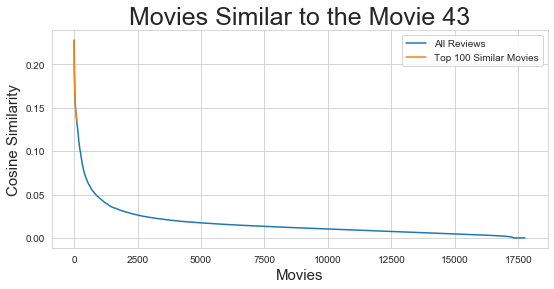

In [73]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.plot(similarities[sim_indexes], label = 'All Reviews')
plt.plot(similarities[sim_indexes[:100]], label = 'Top 100 Similar Movies')
plt.title("Movies Similar to the Movie {}".format(id_movie), fontsize = 25)
plt.xlabel("Movies", fontsize = 15)
plt.ylabel("Cosine Similarity", fontsize = 15)
plt.legend()
plt.show()

In [74]:
# Here are the top 10 movies most similar to movie 43
movie_titles.loc[sim_indexes[:10]]

,Year_Launch,Title
ID_Movie,,
6938,1995.0,Battle Skipper
3353,1999.0,Midnight Panther
15088,1996.0,Yamamoto Yohko: Starship Girl
14888,1996.0,Ayane's High Kick
7550,1996.0,Big Wars
3257,1990.0,Takegami: Guardian of Darkness: War God
8115,2000.0,Virgin Fleet
1054,1986.0,Odin: Photon Space Sailer Starlight
11436,1995.0,Super Atragon


# End